In [369]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import  scipy as sp
import quandl
import functools
import seaborn as sns
from sklearn.metrics import mean_squared_error
from itertools import accumulate
import operator


import nasdaqdatalink as ndl
ndl.ApiConfig.api_key = '1tmjmeNoSxdLjAa-cHZ-'
import nasdaqdatalink as ndl

In [370]:
pd.set_option('display.max_columns',None)

In [371]:
def compute_bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        print('No times')
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

def computing_both_prices(zcb, coupon_rate):
    double = pd.DataFrame(columns=['Initial','Week'], index=zcb.index)
    for i in range(len(double)-1):
        double.iloc[i]['Initial'] = compute_bond_price(zcb.iloc[i],coupon_rate.iloc[i][5],5)
        double.iloc[i]['Week'] = compute_bond_price(zcb.iloc[i+1],coupon_rate.iloc[i+1][5],259/52)
    return double

# Loading in all the Data - FX and Yield Curves

To start simple, I import USDGBP rates.

In [372]:
USDGBP = ndl.get('CUR/GBP', start_date = '2014-12-01', end_date = '2023-02-28').resample('W-WED').ffill()\
.rename(columns = {'RATE':'USDGBP'})

In [373]:
USDGBP

,USDGBP
DATE,
2014-12-03,0.637756
2014-12-10,0.636345
2014-12-17,0.642142
2014-12-24,0.642895
2014-12-31,0.641866
...,...
2023-02-01,0.812038
2023-02-08,0.829610
2023-02-15,0.823083


Nice check that the Rates are below 1 so we got the data the right way round.

## Yield Curves and FX rates for Vietnamese Dong, Thai Baht, Pakistani Rupee and Philippine Peso.

In [397]:
fx_thai = ndl.get('CUR/THB', start_date = '2014-12-01', end_date = '2023-02-28').rename(columns = {'RATE':'THBfx'}).resample('W-WED').ffill()
fx_viet = ndl.get('CUR/VND', start_date = '2014-12-01', end_date = '2023-02-28').rename(columns = {'RATE':'VNDfx'}).resample('W-WED').ffill()
fx_pak = ndl.get('CUR/PKR', start_date = '2014-12-01', end_date = '2023-02-28').rename(columns = {'RATE':'PKRfx'}).resample('W-WED').ffill()
fx_phil = ndl.get('CUR/PHP', start_date = '2014-12-01', end_date = '2023-02-28').rename(columns = {'RATE':'PHPfx'}).resample('W-WED').ffill()

yd_thai = ndl.get('YC/THA', start_date = '2014-12-01', end_date = '2023-02-28')\
[['1-Year','3-Year','5-Year', '10-Year']].rename(columns = {'1-Year':1,'3-Year':3,'5-Year':5, '10-Year':10})

yd_viet = ndl.get('YC/VNM', start_date = '2014-12-01', end_date = '2023-02-28')\
[['1-Year','3-Year','5-Year', '10-Year']].rename(columns = {'1-Year':1,'3-Year':3,'5-Year':5, '10-Year':10})

yd_pak = ndl.get('YC/PAK', start_date = '2014-12-01', end_date = '2023-02-28')\
[['12-Month','3-Year','5-Year', '10-Year']].rename(columns = {'12-Month':1,'3-Year':3,'5-Year':5, '10-Year':10})

yd_phil = ndl.get('YC/PHL', start_date = '2014-12-01', end_date = '2023-02-28')\
[['1-Year','3-Year','5-Year', '10-Year']].rename(columns = {'1-Year':1,'3-Year':3,'5-Year':5, '10-Year':10})

yd_thai = yd_thai.resample('W-WED').ffill()/100
yd_viet = yd_viet.resample('W-WED').ffill()/100
yd_pak = yd_pak.resample('W-WED').ffill()/100
yd_phil = yd_phil.resample('W-WED').ffill()/100

zcb_thai = compute_zcb_curve(yd_thai.T).T
zcb_viet = compute_zcb_curve(yd_viet.T).T
zcb_pak = compute_zcb_curve(yd_pak.T).T
zcb_phil = compute_zcb_curve(yd_phil.T).T

#And the OISs

issc = ndl.get('YC/GBR_ISSC',start_date = '2014-12-01', end_date = '2023-02-28')
isss = ndl.get('YC/GBR_ISSS',start_date = '2014-12-01', end_date = '2023-02-28')
ois = pd.concat([issc.loc[:'2021-01-01'], isss.loc['2021-01-02':]], axis=0).resample('W-WED').last().ffill().loc['2014-12-01':]/100



We now need to calculate the bond prices, using our previously calculated zcb and the coupon rates.

For each bond at each date, we need to know firstly its price at the beginning of the strategy, and then a week later.

In [399]:
def compute_bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        print('No times')
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

This function computes the bond prices and their price after a week.

In [443]:
def computing_both_prices(zcb, coupon_rate):
    price_initial = pd.DataFrame(columns=['Initial'], index=zcb.index)
    price_week = pd.DataFrame(columns=['Week'], index=zcb.index)
    for i in range(len(price_initial)-1):
        price_initial.iloc[i]['Initial'] = compute_bond_price(zcb.iloc[i],coupon_rate.iloc[i][5],5)
        price_week.iloc[i]['Week'] = compute_bond_price(zcb.iloc[i+1],coupon_rate.iloc[i+1][5],259/52)
    return(price_initial,price_week)

In [444]:
price_thai = computing_both_prices(zcb_thai, yd_thai)
price_viet = computing_both_prices(zcb_viet, yd_viet)
price_pak = computing_both_prices(zcb_pak, yd_pak)
price_phil = computing_both_prices(zcb_phil, yd_phil)

# Now that we have all the data, on to the algorithm

I need to write out what we are going to do to code it more effectively.


First, we borrow 8 million dollars with GBP. We also own 2 million USD.

We use this to buy bonds in a foreign currency, if they pay more than 50bp + interest on gbp.

Sell these bonds after a week, which are worth more now than they were a week ago.

Convert money back to usd and pay the interest on the 8 million dollar worth of gbp.




In [448]:
def carry_trade(USDGBP, yd, price_initial, price_week, ois, fx):
    
    yiel = yd[:'2022-12-19'][5]
    fx = fx[:'2022-12-19']
    initial_price = price_initial[:'2022-12-19']['Initial']
    week_price = price_week[:'2022-12-19']['Week']
    USDGBP = USDGBP[:'2022-12-19']
    ois5 = ois[:'2022-12-19']['5.0Y']
    ois008 = ois[:'2022-12-19']['0.08Y']
    
    pnl = [0] * len(yiel)
    k = 0
    for i in range(len(yiel)-1):
        if yiel[i] > ois5[i] + 0.005:
            #what its going to cost to borrow the GBP
            amount_of_gbp_borrowed = 8000000 * USDGBP.iloc[i]
            #if k == 0:
                #print(amount_of_gbp_borrowed)
                
            #how many bonds we can buy
            total_USD = 10000000
            total_foreign_currency = total_USD*fx.iloc[i]
            
            number_of_bonds = total_foreign_currency/initial_price[i]
            #if k==0:
           #     print('blue' + str(number_of_bonds))
            '''
            total USD = 10M
            buy bonds, total USD = 0
            we own number of bonds * bond value and have foreign currency
            we earn interest in foreign currency
            we sell these bonds and have foreign currency
            transfer back this foreign currency total usd = >10M hopefully
            '''
            
            #this is what we earn holding bonds a week in the foreign currency
            interest_pnl = number_of_bonds * yiel[i] * initial_price[i]
            #if k == 0:
                #print('interest + this is in foreign currency ' + str(interest_pnl))
            
            #this is what these bonds we held are worth after selling them and converting into USD
            value_of_these_bonds = number_of_bonds*week_price[i]/fx.iloc[i+1]
            
            bond_pnl = value_of_these_bonds - 10000000
            #if k == 0:
                #print('bond - this is in USD ' + str(bond_pnl))
            #convert interest pnl in usd
            interest_pnl = interest_pnl / fx.iloc[i+1]
            
            
            #and now pay back the gbp
            
            how_many_dollars_do_we_send_back_to_pay_8M = amount_of_gbp_borrowed * (1 +((ois008.iloc[i]+0.005)/52))\
            / (USDGBP.iloc[i+1])#at the new interest rate
            
            gbp_pnl = 8000000 - how_many_dollars_do_we_send_back_to_pay_8M
            #print('a' + str(gbp_pnl[0]))
            #print('b' + str(bond_pnl[0]))
            #if k == 0:
                #print('gbp - this is in usd ' + str(gbp_pnl))
            #so in the end, we have the interest gained
            
            pnl[i] = (gbp_pnl[0] + bond_pnl[0]).astype(float)
            
            
            
            #print(pnl[i])
    data = yiel.to_frame()
    data['pnl'] = pnl
    data['cumpnl'] = np.cumsum(pnl)
        #print('final' + str(pnl[i]))
    return(data[['pnl','cumpnl']])


In [449]:
carry_trade(USDGBP, yd_thai, price_thai[0], price_thai[1], ois, fx_thai)

,pnl,cumpnl
Date,,
2014-12-03,-5246.517033,-5.246517e+03
2014-12-10,38428.805818,3.318229e+04
2014-12-17,33909.802498,6.709209e+04
2014-12-24,-13269.995826,5.382210e+04
2014-12-31,251814.970022,3.056371e+05
...,...,...
2022-11-16,0.000000,1.776124e+06
2022-11-23,0.000000,1.776124e+06
2022-11-30,0.000000,1.776124e+06


# Now we test the Carry trade algorithm on currency pairs.

# Viet Dong

In [458]:
viet = carry_trade(USDGBP, yd_viet, price_viet[0], price_viet[1], ois, fx_viet)
viet

,pnl,cumpnl
Date,,
2014-12-03,2916.805431,2.916805e+03
2014-12-10,70158.717241,7.307552e+04
2014-12-17,17818.609214,9.089413e+04
2014-12-24,997.272556,9.189140e+04
2014-12-31,242292.890934,3.341843e+05
...,...,...
2022-11-16,-29944.831861,3.202854e+06
2022-11-23,20476.077349,3.223330e+06
2022-11-30,234297.228217,3.457627e+06


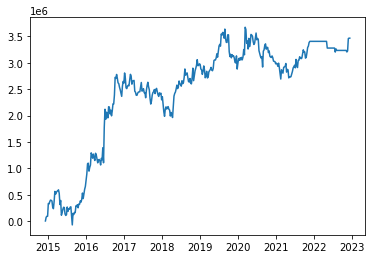

In [459]:
plt.plot(viet['cumpnl'])

# Thai Baht

In [454]:
thai = carry_trade(USDGBP, yd_thai, price_thai[0], price_thai[1], ois, fx_thai)
thai

,pnl,cumpnl
Date,,
2014-12-03,-5246.517033,-5.246517e+03
2014-12-10,38428.805818,3.318229e+04
2014-12-17,33909.802498,6.709209e+04
2014-12-24,-13269.995826,5.382210e+04
2014-12-31,251814.970022,3.056371e+05
...,...,...
2022-11-16,0.000000,1.776124e+06
2022-11-23,0.000000,1.776124e+06
2022-11-30,0.000000,1.776124e+06


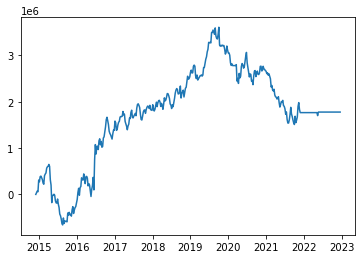

In [457]:
plt.plot(thai['cumpnl'])

# Pakistani Rupee

In [460]:
pak = carry_trade(USDGBP, yd_pak, price_pak[0], price_pak[1], ois, fx_thai)
pak

,pnl,cumpnl
Date,,
2014-12-03,10753.068408,10753.068408
2014-12-10,54572.750635,65325.819043
2014-12-17,50421.187422,115747.006466
2014-12-24,3212.932978,118959.939444
2014-12-31,267240.780226,386200.719669
...,...,...
2020-03-04,-101833.708640,NaN
2020-03-11,277759.310717,NaN
2020-03-18,39582.518814,NaN


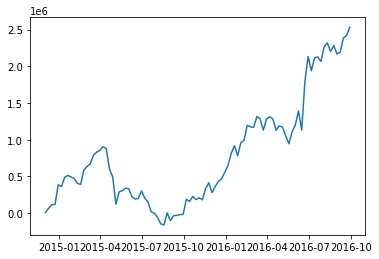

In [461]:
plt.plot(pak['cumpnl'])

# Philippine Peso

In [462]:
phil = carry_trade(USDGBP, yd_phil, price_phil[0], price_phil[1], ois, fx_phil)
phil

,pnl,cumpnl
Date,,
2014-12-03,12573.742836,1.257374e+04
2014-12-10,40252.206617,5.282595e+04
2014-12-17,36368.420074,8.919437e+04
2014-12-24,-27703.252102,6.149112e+04
2014-12-31,179099.172071,2.405903e+05
...,...,...
2022-11-16,39767.341928,3.008146e+06
2022-11-23,77837.650727,3.085984e+06
2022-11-30,88494.621827,3.174478e+06


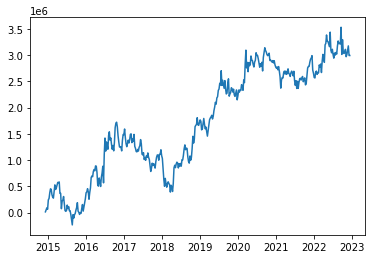

In [528]:
plt.plot(phil['cumpnl'])

Clearly these carry trades work, rather very well. I'll now compute some metrics on these curves and on the simple pnl ones.

The Philippine Peso and Vietnamese Dong are the best performers on our sample, with 3-3.5M dollars in pnl each, but both other currencies proved to have good results.

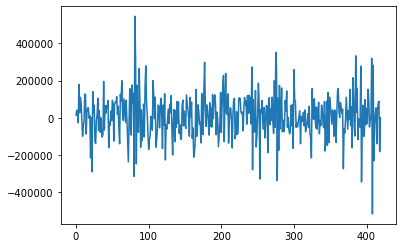

In [488]:
plt.plot(phil['pnl'].to_list())

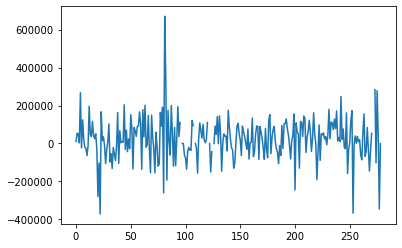

In [485]:
plt.plot(pak['pnl'].to_list())

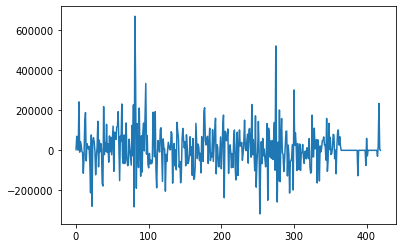

In [486]:
plt.plot(viet['pnl'].to_list())

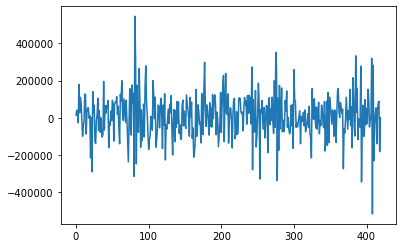

In [487]:
plt.plot(phil['pnl'].to_list())

I think it would be interesting to get the ROC, to see if this strategy is really worth it, especially since we have invested a substantial amount.

In [ ]:
plt.plot(phil['cumpnl'])

In [497]:
phil_roc = (phil['pnl']/10000000).mean()
pak_roc = (pak['pnl']/10000000).mean()
viet_roc = (viet['pnl']/10000000).mean()
thai_roc = (thai['pnl']/10000000).mean()

In [504]:
rocs = [phil_roc,pak_roc,viet_roc,thai_roc]

[0.000712252333413358,
 0.002329336724548672,
 0.0008249836995550862,
 0.00042288664395256513]

In [514]:
rocsweekly = list(map(lambda x : x + 1, rocs))
rocsweekly

[1.0007122523334133, 1.0023293367245487, 1.000824983699555, 1.0004228866439526]

In [ ]:
This is the average weekly RoC, the pakistani carry trade has the largest RoC. Annualy, these translate to:

In [517]:
rocsannual = list(map(lambda x : x ** 52, rocsweekly))
rocsannual

[1.0377178611291547,
 1.1286075963620104,
 1.0438141606264157,
 1.0222289182252027]

These weekly RoCs can be extrapolated to 12% anual RoC for the pakistani one, which is very decent. Overall, though, we do not observe very large returns.

# Overall Comments

The carry trade is a well know relatively safe trading strategy. As we can see, we observe consitent positive RoC. However, for such large investments with returns not guaranteed to be over 12%